In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Проводится A/B-тестирование для двух вариантов рекомендаций сопутствующих товаров в профиле товара некоторого интернет-магазина. 

Вариант 1. Дополнительные товары рекомендуются на основе статистических данных уже совершённых покупок — товары, которые другие пользователи часто покупают с основным. 
Вариант 2. Дополнительные товары рекомендуются на основе совершённых пользователем ранее покупок с помощью ML-модели.
Варианты сравниваются по доле пользователей, которые добавляют хотя бы один из предложенных товаров в корзину (метрикой является конверсия действия «добавить в корзину сопутствующий товар»).

Для этого пользователи были разделены на две группы. 

Контрольной (группе А) доступен первый вариант рекомендаций.
Тестовой (группе B) доступен второй вариант. 
Предполагается, что все условия и принципы проведения A/B-теста были соблюдены, то есть:

✔️ выборка имеет достаточный для принятия решения объём;

✔️ выбран достаточный интервал времени для тестирования;

✔️ группы максимально сбалансированы;

✔️ внешнее вмешательство минимально.

Итак, в результате проведения A/B-тестирования были получены следующие данные:
На основании этих данных нам предстоит сделать вывод о том, какой из вариантов рекомендаций (А или B) является более эффективным по показателю конверсии.

In [2]:
ab_data = pd.read_csv('data/ab_data.zip',sep=',')

In [3]:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


Итак, мы получили таблицу со следующими полями:

Название поля - Описание
* user_id	 - идентификатор пользователя, зашедшего на сайт
* timestamp	 - дата события
* group	 - группа теста (контрольная или тестовая)
* converted	- совершил пользователь целевое действие (нажатие кнопки «добавить в корзину» на сопутствующем товаре) или нет. 1 — да, 0 — нет.

In [4]:
#Посмотрим тип данных и содержание каждого столбца, для этого применим к датафрейму метод info():
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


Итак, в наших данных нет пропусков, однако нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime. Напомним: для этого мы можем воспользоваться функцией pandas to_datetime:

In [5]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

В итоге мы получили таблицу, в которой отображены входы клиента на сайт (сессия) и его действия. 
Для того, чтобы получить показатель конверсии в группах на каждый день, нам необходимо предварительно сгруппировать наши данные по дате и группе и вычислить количество пользователей, заходивших на сайт, и суммарное количество совершённых целевых действий. 

Дополнительно для удобства сбросим индекс на сгруппированной таблице c помощью метода reset_index() и переименуем столбец user_id в users_count с помощью метода rename().

In [6]:
daily_data = ab_data.groupby(['timestamp','group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id': 'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


### Примечание. 
Количество пользователей в день в контрольной и тестовой группе определяется как количество значений в столбце user_id в сгруппированных данных, а количество совершённых целевых действий — это просто сумма по столбцу converted (1 в строке означает положительный исход, то есть целевое действие было совершено, а 0 — отрицательный исход; просуммировав все 1 и 0 в группе, получим количество положительных исходов).

Для завершения этапа подготовки данных к анализу нам осталось рассчитать конверсию на каждый день проведения A/B-тестирования. Напомним: ежедневная конверсия рассчитывается как отношение числа посетителей сайта, выполнивших на нём какие-либо целевые действия в день, к ежедневному общему числу посетителей сайта, умноженная на 100 %: 

conv = N1/N * 100

N1 — количество посетителей сайта, выполнивших целевое действие в день ;
N — общее количество посетителей сайта в день ;
cpnv — конверсия в день .

In [7]:
daily_data['conversion'] = daily_data['converted'] / daily_data['users_count'] * 100
daily_data.head()

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063
3,2017-01-03,B,6620,754,11.389728
4,2017-01-04,A,6573,797,12.125361


In [8]:
daily_data[(daily_data['timestamp']=='2017-01-05') & (daily_data['group']=='A')]['conversion'] # проверка по нужной дате и группе

6    12.322792
Name: conversion, dtype: float64

## ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ

Нам необходимо ответить на вопрос: в какой группе (А или B) показатель конверсии был выше, и на этой основе принять решение о том, какой из вариантов более эффективный. 

Давайте построим диаграмму boxplot для сравнения параметров распределения ежедневной конверсии по группам. 

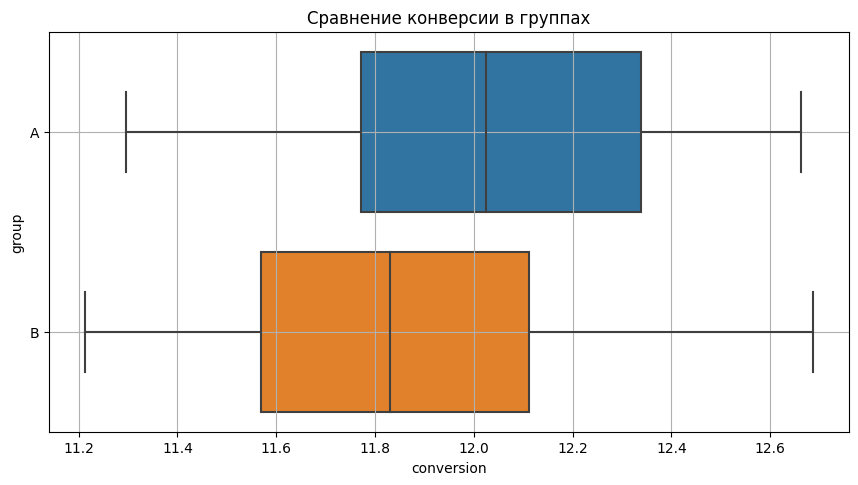

In [9]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid(True);

Что можно сказать исходя из этого графика? Во-первых, медианное значение ежедневной конверсии в группе А, выше, чем в группе B. Во-вторых, разброс конверсии в группе B несколько больше, чем в группе A.

Тут неопытный специалист воскликнет: версия рекомендаций А лучше, чем версия B (медиана конверсии варианта А больше, да и разброс поменьше, то есть конверсия более стабильна) — и завершит эксперимент. 

Но выводы делать ещё рано! И сейчас попробуем понять, почему. 

### Примечание. 
Прежде чем делать выводы по визуальному представлению данных, всегда обращайте внимание на численные значения показателей. Они могут различаться в масштабе графика, но на практике разница между ними не будет иметь значения. Также всегда стоит убедиться, что в данных нет выбросов (базовый вариант — сравнить медиану и среднее между собой). Далее мы ещё поговорим о стабилизации показателя во времени.

Давайте вычислим средний и медианный показатель конверсии в контрольной и тестовой группе и умножим результат на 100 (получим результат в процентах):

In [10]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
group,,
A,12.032876,12.024261
B,11.872697,11.829582


Из полученной таблицы видно, что медиана и среднее в каждой группе практически совпадают. При этом разница между показателями в группах менее 0.3 %! 

Возникает вопрос: а значима ли вообще такая разница в показателях или она обусловлена случайностью, и варианты A и B одинаково эффективны по метрике конверсии?

Прежде чем отвечать на этот вопрос, нам нужен ответ на другой вопрос: а стабилен ли показатель конверсии в группах во времени или он колеблется как «уж на сковородке»? 

## Примечание. 
Вопрос о стабильности метрик является обязательным. Прогонять результаты через статистические тесты можно только после того, как вы убедитесь, что разница в ваших показателях стабилизировалась во времени. Это связано с проблемой подглядывания, речь о которой пойдёт ниже.

Тут нам помогут кумулятивные метрики.

В течение всего теста рекомендуется отслеживать поведение целевых метрик. Для этого чаще всего используются кумулятивные метрики.

### Кумулятивная метрика — это отображение целевой метрики, когда вы отслеживаете её поведение за каждый день — накопленным итогом по дням. 

## ПОЧЕМУ ЭТО ВАЖНО?

Ранее мы говорили, что для принятия решения в A/B-тестировании требуется большой объём данных, что соотносится с законом больших чисел: чем больше данных — тем ближе получаемый результат к математическому ожиданию (истинному среднему). 

Вспомните пример про подбрасывание монетки. Если подбросить монетку 10 раз, то велика вероятность, что один из двух результатов будет значительно превышать второй. Но если подбросить её 1 000 раз, то результаты компенсируют друг друга, и мы увидим, что итог крайне близок к разделению 50/50 (количество выпавших орлов и решек будет практически одинаковым).

Так же и в A/B-тестировании: с самого начала любой из вариантов может показывать лучшие результаты, и статистическая значимость может быть достигнута уже в первые дни теста. Это явление называется проблемой подглядывания.

## Важно! Не стоит торопиться: как минимум дождитесь накопления запланированных объёмов выборки и длительности теста. Но и тут не стоит заканчивать тест — проверьте, стабилизировались ли метрики!

То есть в начале теста любой полученный за день результат будет оказывать сильное влияние на результат теста. Но со временем данные будут накапливаться, и доля получаемых за день данных будет всё меньше и меньше воздействовать на уже накопленный результат.

Согласно центральной предельной теореме и закону больших чисел, с увеличением объёма данных метрика стабилизируется и будет стремиться к реальному среднему. 

## Примечание. В качестве кумулятивной метрики можно считать не только конверсию, но и выручку, средний чек, количество заказов, процент негативных комментариев, точность модели и так далее.

Итак, давайте применим новые знания к нашим данным и вычислим кумулятивную конверсию, а затем построим её график. 

Но для начала ради эксперимента посмотрим, как вообще изменялись показатели ежедневной конверсии в каждой группе во времени. Для этого построим линейные графики для каждой группы: по оси абсцисс отложим дату, а по оси ординат — показатель конверсии:

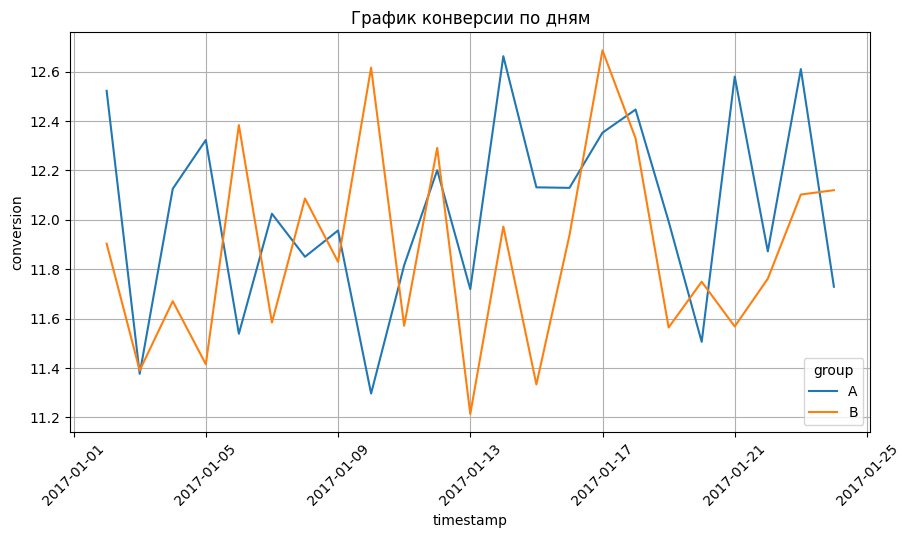

In [11]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать по такому графику? Да практически ничего! Конверсия у обеих групп «скачет» день ото дня. Понять, какая из групп лучше, — практически невыполнимая задача. 

Именно поэтому и принято смотреть график кумулятивной конверсии, где за каждый день отображаются данные накопленным итогом.

Для расчёта кумулятивного показателя суммы в Pandas есть специальный метод cumsum(). 
Давайте посмотрим, как он работает — сначала на данных о ежедневном количестве посетителей для группы А. 

Выберем данные для группы А и создадим в полученной таблице новый столбец cum_users_count, в который запишем результат работы метода cumsum() по столбцу users_count:

In [12]:
# выделяем данные группы А
daily_data_a = daily_data[daily_data['group'] == 'A']
# считаем кумулятивное количество посетителей
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
# выводим время, количество посетителей и кумулятивное количество посетителей
display(daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head())

C:\Users\пользователь\AppData\Local\Temp\ipykernel_8624\906787284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


Обратите внимание, что в столбце с кумулятивной суммой за 2017-01-03 указано 9 435 пользователей. Сложите данные за 2017-01-02 и 2017-02-03 из столбца users_count — получите те же 9 435. Аналогично и для других дней. 

То есть кумулятивная сумма — это накопительная сумма; каждое её значение — это результат сложения показателя за предыдущие дни с показателем за текущий день. 

Как сделать такой расчёт для двух групп (А и B) сразу? Воспользуемся методом groupby: сгруппируем данные по признаку группы, и в каждой группе будем вычислять кумулятивные суммы признаков количества посетителей (users_count) и количества совершённых целевых действий (converted). 

После этого рассчитаем кумулятивную конверсию — это отношение ежедневной кумулятивной суммы количества посетителей к ежедневной кумулятивной сумме количества совершённых целевых действий:

In [13]:
# вычисляем кумулятивную сумму количества посетителей
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
# вычисляем кумулятивную сумму количества совершённых целевых действий
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
display(daily_data.head())

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,12.521922,2851,357,12.521922
1,2017-01-02,B,2848,339,11.903090,2848,339,11.903090
2,2017-01-03,A,6584,749,11.376063,9435,1106,11.722311
3,2017-01-03,B,6620,754,11.389728,9468,1093,11.544149
4,2017-01-04,A,6573,797,12.125361,16008,1903,11.887806


А теперь построим графики кумулятивной конверсии по дням в каждой группе:

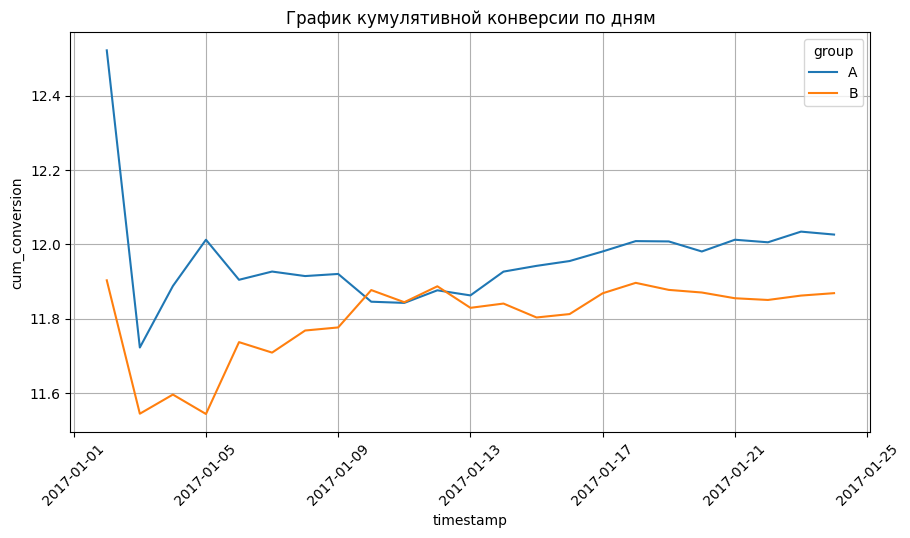

In [14]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='timestamp', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Что можно сказать теперь? До 2017-01-09 конверсия была нестабильна, но после 2017-01-11 резкие скачки прекратились (кривая графика переходит в прямую). Судя по графику, конверсия группы B стабильно хуже конверсии группы А на всём промежутке времени. 

Обратите внимание на различие в конверсии в первые дни теста: тут наглядно отображена проблема подглядывания, когда статистическая значимость ошибочно могла быть достигнута уже в самом начале теста.

На основании стабилизированного кумулятивного графика мы можем сделать вывод, что длительность эксперимента была достаточной для того, чтобы судить о статистической значимости разности между показателем конверсии в группах.

⭐️ Значит, мы можем переходить к проведению статистических тестов. Но прежде предлагаем решить несколько заданий.

# Самостоятельная работа
Каждая таблица имеет следующие поля:

date — дата наблюдения;
cid — идентификатор посетителя;
transactions — количество совершённых целевых действий (транзакций);
revenue — сумма покупки;
group — группа (тестовая — А, контрольная — B).

In [15]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.zip', sep=',')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.zip', sep=',')
sample_result = pd.concat([sample_a, sample_b])

In [16]:
sample_result['date'] = pd.to_datetime(sample_result['date'], format='%Y-%m-%d')

In [17]:
daily_sample = sample_result.groupby(['date','group']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'
}).reset_index().rename(columns={'cid': 'cid_count'})
daily_sample.head()

,date,group,cid_count,transactions,revenue
0,2020-11-06,A,2576,16,1577279
1,2020-11-06,B,2499,19,996645
2,2020-11-07,A,2704,23,1721886
3,2020-11-07,B,2804,19,555499
4,2020-11-08,A,3354,25,846051


In [18]:
daily_sample[(daily_sample['date']=='2020-11-08') & (daily_sample['group']=='A')] #сколько было 8.11.202 по группе А

,date,group,cid_count,transactions,revenue
4,2020-11-08,A,3354,25,846051


In [19]:
#Добавьте в каждую из таблиц кумулятивные метрики:

#кумулятивное количество посетителей сайта;
#кумулятивное суммарное число транзакций;
#кумулятивная общая сумма покупок (кумулятивная выручка).
#Рассчитайте кумулятивную конверсию действия покупки (в процентах) и кумулятивный средний чек (кумулятивная выручка/кумулятивное суммарное число транзакций).


# вычисляем кумулятивную сумму количества посетителей
daily_sample['cum_cid_count'] = daily_sample.groupby(['group'])['cid_count'].cumsum()
# вычисляем кумулятивную сумму количества транзакций
daily_sample['cum_transactions'] = daily_sample.groupby(['group'])['transactions'].cumsum()
# вычисляем кумулятивную выручку
daily_sample['cum_revenue'] = daily_sample.groupby(['group'])['revenue'].cumsum()

# вычисляем кумулятивную конверсию
daily_sample['cum_conversion'] = daily_sample['cum_transactions']/daily_sample['cum_cid_count'] * 100

#вычисляем кумулятивную среднюю выручку
daily_sample['cum_mean_pay'] = daily_sample['cum_revenue']/daily_sample['cum_transactions']

daily_sample

,date,group,cid_count,transactions,revenue,cum_cid_count,cum_transactions,cum_revenue,cum_conversion,cum_mean_pay
0,2020-11-06,A,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
1,2020-11-06,B,2499,19,996645,2499,19,996645,0.760304,52455.000000
2,2020-11-07,A,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
3,2020-11-07,B,2804,19,555499,5303,38,1552144,0.716576,40845.894737
4,2020-11-08,A,3354,25,846051,8634,64,4145216,0.741256,64769.000000
5,2020-11-08,B,3291,24,3044842,8594,62,4596986,0.721434,74144.935484
6,2020-11-09,A,3234,18,708830,11868,82,4854046,0.690934,59195.682927
7,2020-11-09,B,3062,25,1285836,11656,87,5882822,0.746397,67618.643678
8,2020-11-10,A,3022,29,826984,14890,111,5681030,0.745467,51180.450450
9,2020-11-10,B,3072,30,2414726,14728,117,8297548,0.794405,70919.213675


In [20]:
#Чему равна средняя кумулятивная конверсия в группах за весь период проведения A/B-теста? Ответ округлите до сотых, знаки процентов не вводите.
display(round(daily_sample[daily_sample['group']=='A']['cum_conversion'].mean(), 2))
display(round(daily_sample[daily_sample['group']=='B']['cum_conversion'].mean(), 2))

0.71

0.76

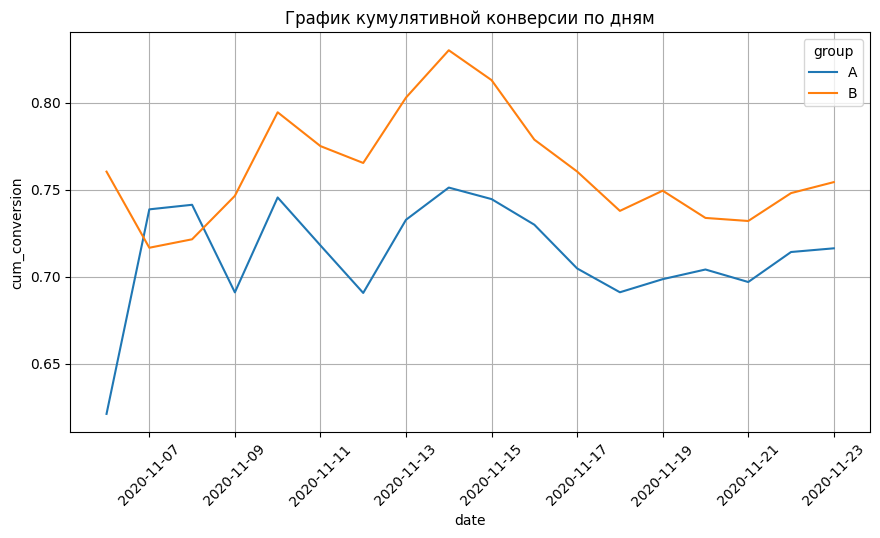

In [21]:
#график кумулятивных функций конверсии



# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_sample, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

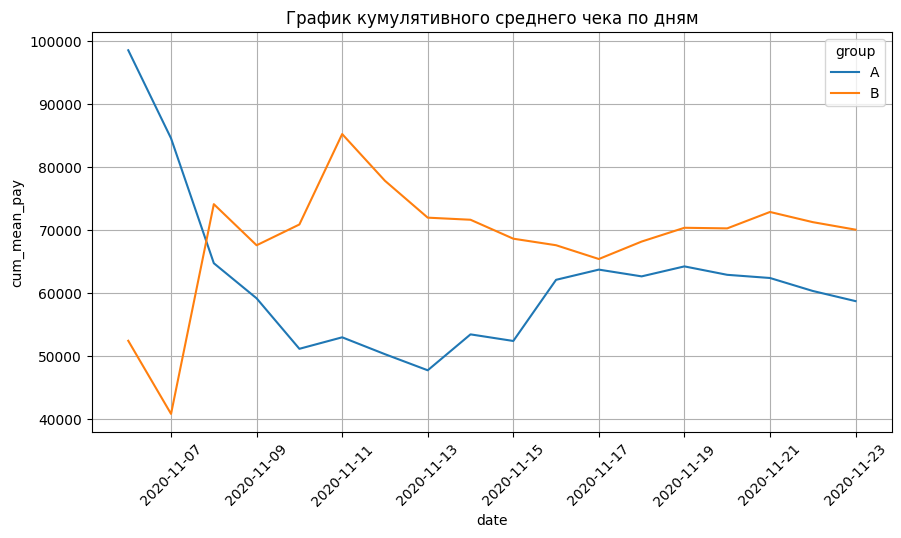

In [22]:
#график кумулятивных функций среднего чека



# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_mean_pay', data=daily_sample, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

## СТАТИСТИЧЕСКИЙ ТЕСТ ДЛЯ КОНВЕРСИИ

Нулевая гипотеза нашего теста всегда будет звучать следующим образом:

H0: pa = pb  то есть истинные пропорции в группах равны.
А вот альтернативных может быть несколько:

H1 (двусторонняя): pa != pb, то есть истинные пропорции в группах не равны.
H1 (левосторонняя): pa < pb, то есть истинная пропорция группы А меньше, чем в группе B.
H1 (правосторонняя): pa > pb, то есть истинная пропорция группы А больше, чем в группе B.

✏️ Применим z-тест для пропорций на примере конверсии нашего интернет-магазина. 

Импортируем функцию proportions_ztest() из модуля statsmodels:

In [23]:
from statsmodels.stats.proportion import proportions_ztest

Напомним, что для получения z-статистики и p-value нам необходимо передать в функцию следующие аргументы:

* count — количество «успехов» (в каждой из групп). В нашем случае — количество пользователей, которые совершили целевое действие в каждой группе.
* nobs — количество наблюдений (в каждой из групп), то есть размер выборки.
* alternative — альтернативная гипотеза. Может быть: 'two-sided' — двусторонняя, 'smaller' — левосторонняя, 'larger' — правосторонняя. По умолчанию параметр равен 'two-sided'. 

✏️ Итак, сгруппируем данные по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы.

In [24]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


Итак, будем проверять следующую новую гипотезу:

pa = pb , то есть конверсии в группах А и B равны.
При правосторонней альтернативной гипотезе (ранее из кумулятивных графиков мы видели, что кумулятивная конверсия в группе А выше, чем в группе B, поэтому мы хотим удостовериться в этом с помощью статистического теста, и нам подойдёт правосторонняя гипотеза):

pa > pb, то есть конверсия в группе А выше, чем конверсия в группе B.
Зададим уровень значимости a=0.05 и будем сравнивать полученное p-value с ним. По умолчанию функция proportions_ztest() возвращает z-статистику и p-value для двусторонней альтернативной гипотезы (конверсии в группах не равны). 

✏️ Z-статистика нас пока что не интересует, а вот p-value занесём в отдельную переменную для дальнейшего сравнения с уровнем значимости.

In [25]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Что это значит для нас и для бизнеса? Так как z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то полученная разница в метрике в группах статистически не значима. Переводим на язык бизнеса: разницы между вариантами рекомендаций сопутствующих товаров нет — они одинаково эффективны по метрике конверсии! 

На основе этого вывода мы принимаем решение о том, что делать дальше. Возможные варианты:

* отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить использование текущей версии рекомендаций;
* попытаться усовершенствовать модель и провести тестирование снова;
* использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.

### Примечание. 
Важно отметить, что тест для пропорций можно применять не только к конверсии. Например, так же можно оценивать долю больных людей, долю просроченных кредитов и так далее.

✏️ Заметим, что, если повысить уровень значимости до a=0,1 , то есть «ослабить» требование по точности, можно получить уровень конверсии в группе А, всё-таки превышающий конверсию в группе B. Выполните предыдущий код, чтобы убедиться в этом. Предварительно задайте значение переменной a=0,1. 

Результат должен быть следующим:

p-value:  0.1
Отвергаем нулевую гипотезу. Конверсии в группах А и B равны
Альтернативная гипотеза. H1: Конверсия в группе А выше, чем конверсия в группе B

## СТАТИСТИЧЕСКИЕ ТЕСТЫ ДЛЯ ДРУГИХ МЕТРИК

Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательная для наших посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 5 %.

In [26]:
#читаем архив
from zipfile import ZipFile
archive = 'data/time_data.zip'
zip_file = ZipFile(archive)

time_data = 0
for text_file in zip_file.infolist():
    if text_file.filename.endswith('.xlsx'):
        time_data = pd.read_excel(zip_file.open(text_file.filename))


time_data.head()

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


✏️ Построим гистограмму времени, проведённом пользователями на сайте в каждой из групп:

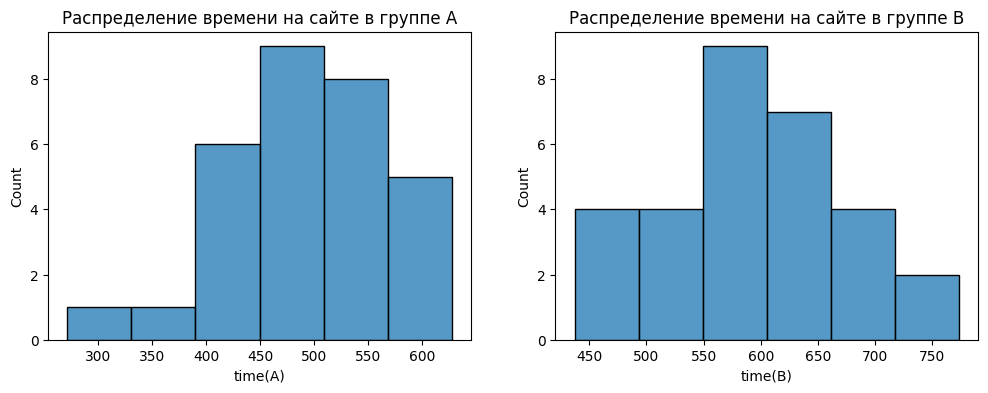

In [27]:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

Гистограммы напоминают нормальное распределение. Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия Шапиро-Уилка. Для этого используем функцию shapiro() из модуля scipy.stats:

In [28]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value группы А 0.43
# p-value группы B 0.12
# Принимаем нулевую гипотезу. Распределения в обеих группах нормальные

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом для того, чтобы сравнить среднее время посещения сайта в группах.

Выдвигаем нулевую гипотезу:

H0: pa = pb, то есть среднее время в группах А и B одинаково.
При левосторонней альтернативной гипотезе:

H1: pa = pb, то есть среднее время в группе А меньше, чем в группе B.

✏️ Применим T-тест для сравнения средних — функцию ttest_ind() из модуля scipy.stats. Обратите внимание, что левосторонняя альтернативная гипотеза в модуле scipy указывается в параметре alternative как 'less' (правосторонняя — 'greater’):

In [29]:
from scipy.stats import ttest_ind
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value: 0.0
# Отвергаем нулевую гипотезу. Среднее время в группах одинаково
# Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


## Обратите внимание: 
мы запрашивали значение p-value, округлённое до двух знаков после запятой, но на выводе получили 0.0 — значение только с одним знаком после запятой. Где же второй? Дело в том, что Python не выводит на конце числа больше одного нуля. Значит, 0.0 следует читать как 0.00. Без округления мы бы увидели значащие цифры далеко после запятой. Однако нас интересуют только две после запятой, потому что с такой точностью задан уровень значимости. Итак, в результате проведения T-теста мы получили p-value = 0 < 0.05, а это значит, что мы отвергаем нулевую гипотезу в пользу альтернативной: среднее время, проводимое на сайте, в группе А меньше, чем в группе B.

Отсюда можно сделать вывод, что что тёмная тема более привлекательна для наших посетителей, чем светлая. 

⭐️ Обратите внимание, что мы опять же принимаем решение, исходя только из одной метрики, так как другими мы и не обладали. Мы проведём комплексный анализ результатов A/B-тестирования по нескольким метрикам в финальном задании модуля. А пока предлагаем вам решить несколько задач!

# Самостоятельная работа

Проверьте гипотезу о равенстве конверсий в группах А и B при альтернативной гипотезе: Конверсия в группе А меньше, чем конверсия в группе B. Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion. В качестве уровня значимости возьмите a=0.1.




In [30]:
# вычисляем  конверсию
daily_sample['conversion'] = daily_sample['transactions']/daily_sample['cid_count'] * 100

converted_piv_sample= daily_sample.groupby('group')['conversion'].agg(
    ['sum', 'count']
)
display(converted_piv_sample)

,sum,count
group,,
A,13.014443,18
B,13.726118,18


In [31]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv_sample['sum'], #число "успехов"
    nobs=converted_piv_sample['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.61
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Проверьте гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка. В качестве уровня значимости возьмите a=0.1.

In [32]:
daily_sample['mean_pay'] = daily_sample['revenue']/daily_sample['transactions']
daily_sample


,date,group,cid_count,transactions,revenue,cum_cid_count,cum_transactions,cum_revenue,cum_conversion,cum_mean_pay,conversion,mean_pay
0,2020-11-06,A,2576,16,1577279,2576,16,1577279,0.621118,98579.937500,0.621118,98579.937500
1,2020-11-06,B,2499,19,996645,2499,19,996645,0.760304,52455.000000,0.760304,52455.000000
2,2020-11-07,A,2704,23,1721886,5280,39,3299165,0.738636,84593.974359,0.850592,74864.608696
3,2020-11-07,B,2804,19,555499,5303,38,1552144,0.716576,40845.894737,0.677603,29236.789474
4,2020-11-08,A,3354,25,846051,8634,64,4145216,0.741256,64769.000000,0.745379,33842.040000
5,2020-11-08,B,3291,24,3044842,8594,62,4596986,0.721434,74144.935484,0.729262,126868.416667
6,2020-11-09,A,3234,18,708830,11868,82,4854046,0.690934,59195.682927,0.556586,39379.444444
7,2020-11-09,B,3062,25,1285836,11656,87,5882822,0.746397,67618.643678,0.816460,51433.440000
8,2020-11-10,A,3022,29,826984,14890,111,5681030,0.745467,51180.450450,0.959629,28516.689655
9,2020-11-10,B,3072,30,2414726,14728,117,8297548,0.794405,70919.213675,0.976562,80490.866667


In [33]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_sample[daily_sample['group']=='A']['mean_pay'])
shapiro_result_b = shapiro(daily_sample[daily_sample['group']=='B']['mean_pay'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value группы А 0.01
p-value группы B 0.02
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


Проверьте гипотезу о равенстве ежедневных средних чеков с помощью критерия Манна-Уитни при альтернативной гипотезе: Ежедневный средний чек в группе А меньше, чем в группе B. Используйте функцию mannwhitneyu() из модуля scipy.stats. В качестве уровня значимости возьмите a=0.1

In [34]:
from scipy.stats import mannwhitneyu
# нулевая и альтернативная гипотезы
H0 = 'Ежедневный средний чек в группах одинаков'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.1 #уровень значимости
#вычисляем результат T-теста для выборок
results = mannwhitneyu(
    x=daily_sample[daily_sample['group']=='A']['mean_pay'],
    y=daily_sample[daily_sample['group']=='B']['mean_pay'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))


p-value: 0.09
Отвергаем нулевую гипотезу. Ежедневный средний чек в группах одинаков
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B


## ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ ИЗВЕСТНОМ ИСТИННОМ СТАНДАРТНОМ ОТКЛОНЕНИИ

In [35]:
n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

In [36]:
from scipy.stats import norm
z_crit = -norm.ppf(alpha/2) # z критическое

In [37]:
eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
 
 
 
# Доверительный интервал: (12180, 20020)

Доверительный интервал: (12180, 20020)


### Примечание. 
Заметьте, что это универсальный код. Если перед вами возникнет другая задача расчёта доверительного интервала для истинного среднего, то вам достаточно будет правильно поменять значения переменных. Вы можете оформить его в виде функции и сохранить её, чтобы не строить каждый раз новый доверительный интервал

⚡ Важно! Доверительный интервал не даёт нам 100 % результата. Всегда есть шанс, что мы промахнулись и не захватили истинного значения. Этот шанс как раз равен уровню значимости .
То есть в нашем примере существует 5 %-ый шанс, что истинное среднее расходов вовсе не лежит в интервале от 12 180 до 20 020. Существует вероятность, что математическое ожидание на самом деле равно 5 000 рублей или 25 000 рублей. Но такая вероятность составляет менее 5 %, и это нас устраивает

Аккумуляторный завод производит батарейки, срок службы которых имеет истинное стандартное отклонение в 2.4 месяца. 
Средний срок службы батареек в случайной выборке из 64 штук составил 12.35 месяца. 
Необходимо построить 90 %-ный доверительный интервал для истинного среднего срока службы производимой батарейки и ответить на вопросы заданий ниже.

In [38]:
n = 64 # размер выборки
x_mean = 12.35 # выборочное среднее
sigma = 2.4 # истинное стандартное отклонение
gamma = 0.9 # уровень надёжности
alpha = 1 - gamma # уровень значимости

z_crit = round(-norm.ppf(alpha/2), 2)

eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound,2), round(upper_bound,2)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

z_crit

Доверительный интервал: (11.86, 12.84)


1.64

## ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ СРЕДНЕГО ПРИ НЕИЗВЕСТНОМ СТАНДАРТНОМ ОТКЛОНЕНИИ

Управляющий супермаркета хочет оценить, сколько денег покупатели тратят за один поход в супермаркет в среднем. На основании ранее собранных данных известно, что расходы одного покупателя распределены приблизительно нормально. Управляющий взял случайную выборку из 15 покупателей и выяснил, что их средние расходы равны 2 000 рублей, а выборочное стандартное отклонение равно 400 рублей.

Для оценки управляющий хочет построить доверительный интервал с надёжностью в 95 %.

Давайте поможем управляющему, решив несколько задачек с помощью Python.

Итак, зададим необходимые для решения задачи переменные:

In [39]:
n = 15 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 2000 # выборочное среднее
x_std = 400 # выборочное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

Найти значение t-критического для любого уровня значимости можно, используя функцию t.ppf() из модуля scipy.stats. 
Для этого в функцию передаётся интересующий уровень значимости (a/2) и число степеней свободы (k = n-1). Аналогично z-критическому функция возвращает отрицательный модуль t-критического, поэтому мы берём его со знаком минус:

In [40]:
from scipy.stats import t
t_crit = -t.ppf(alpha/2, k) # t-критическое

Теперь составим доверительный интервал для истинного среднего. Вычислим левую и нижнюю границу по формуле. Округлим результат и выведем на экран:

In [41]:
eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат
 
 
# Доверительный интервал: (1778, 2222)

Доверительный интервал: (1778, 2222)


## Примечание. 
Важно отметить, что при достаточной выборке (примерно более 30 наблюдений) распределение Стьюдента очень похоже на стандартное нормальное распределение. В этом случае можно использовать первую формулу (z-критическое) даже при неизвестном стандартном отклонении. Однако используя вторую формулу при оценке среднего, вы не ошибётесь.

Ещё один важный факт состоит в том, что обе формулы работают только при соблюдении двух условий:

* Выборка должна быть случайной.
* Выборка должна быть достаточно велика. Но есть исключение: если выборка маленькая, но сама величина распределена нормально, то выборочное среднее тоже будет распределено нормально. В таком случае мы можем пользоваться формулой доверительного интервала.

## Самостоятельная работа
Чиновника интересует сумма подоходного налога, выплачиваемого домохозяйствами за год. На случайной выборке из 25 домохозяйств был посчитан средний размер выплаченного налога, и он составил $ 3 540. Также известно выборочное отклонение величины подоходного налога, равное $ 1 150.

Необходимо найти 90 %-ый доверительный интервал для истинного среднего значения налоговых выплат за год. Используйте формулу с t-критическим.

In [42]:
n = 25 # размер выборки
k = n - 1 # число степеней свободы
x_mean = 3540 # выборочное среднее
x_std = 1150 # выборочное стандартное отклонение
gamma = 0.9 # уровень надёжности
alpha = 1 - gamma # уровень значимости

t_crit = -t.ppf(alpha/2, k) # t-критическое

eps = t_crit * x_std/(n ** 0.5) # погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (3146, 3934)


## ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ ПРОПОРЦИИ

In [43]:
ab_data = pd.read_csv('data/ab_data.zip',sep=',')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


Для удобства создадим отдельные таблицы для каждой из групп пользователей:

In [44]:
#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

Давайте на этот раз оформим расчёт в виде функции: объявим функцию proportions_conf_interval(). 
У данной функции будет три аргумента: 
n — размер выборки, 
x_p — выборочная пропорция,
gamma — уровень надёжности (по умолчанию он равен 0.95). 
Функция будет возвращать кортеж из вычисленных границ доверительного интервала, умноженных на 100 % и округлённых до второго знака после запятой.

In [45]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [46]:
##Теперь применим нашу функцию к данным группы А и группы B:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].count(), # размер выборки
x_p=a_data['converted'].mean() # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].count(), # размер выборки
x_p=b_data['converted'].mean() # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))
# Доверительный интервал для конверсии группы А: (11.86, 12.19)
# Доверительный интервал для конверсии группы B: (11.7, 12.03)

Доверительный интервал для конверсии группы А: (11.86, 12.19)
Доверительный интервал для конверсии группы B: (11.7, 12.03)


✏️ Создадим функцию diff_proportions_conf_interval() со следующими аргументами: 
n — список из размеров выборки для групп А и B соответственно, 
xp — список из выборочных пропорций для групп А и B соответственно,
gamma — уровень надёжности (по умолчанию он равен 0.95). 
Функция будет возвращать кортеж из вычисленных границ доверительного интервала разницы конверсий, умноженных на 100 % и округлённых до второго знака после запятой.

In [47]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [48]:
## Вызовем функцию и построим интересующий нас доверительный интервал:

# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))
 
# Доверительный интервал для разности конверсий: (-0.39, 0.08)

Доверительный интервал для разности конверсий: (-0.39, 0.08)


Итак, что можно сказать теперь? Построенный доверительный интервал с 95 %-ой надёжностью говорит нам, что разница в конверсии между вариантом B и вариантом А лежит в интервале от -0.39 % до 0.08 %. 

То есть разница в конверсии с 95 %-ой надёжностью может быть как положительной, так и отрицательной. Мы имеем дело с третьим случаем — интервал охватывает точку 0.

Отсюда можно сделать вывод, что статистической разницы в конверсии между вариантами А и B не существует, то есть они являются равнозначными по данной метрике.

В заключение хотелось бы отметить, что доверительный интервал для пропорции применяется не только для оценки конверсии и разницы конверсий в группах!

Под истинной пропорцией может пониматься доля успешно угаданных моделью объектов (accuracy), доля выздоровевших пациентов или доля ушедших клиентов (отток). То есть такой доверительный интервал может быть применён в любой задаче A/B-тестирования, где признак, по которому считается метрика, бинарный (имеет два возможных исхода — «успех» и «неуспех»). А это очень большой спектр задач!

Таким образом, доверительные интервалы — это ещё один вспомогательный инструмент проведения A/B-тестирования, который позволяет с определённой заранее надёжностью статистически сравнить варианты продукта А и B по заданной метрике. 

⭐️ Обычно доверительные интервалы используются в комплексе со статистическими тестами. Статистический тест показывает, значимы ли наши результаты, а доверительный интервал показывает пределы изменения метрик и их разницы в группах. 

## Самостоятельная работа
Чтобы оценить удовлетворённость клиентов сети отелей, менеджер взял случайную выборку из 189 комментариев, оставленных посетителями на онлайн-платформе по бронированию, и провёл анализ их содержания. Выяснилось, что 132 комментария были положительными, остальные — негативными.

Чему равна выборочная пропорция положительных комментариев? Укажите с точностью до трёх знаков после разделительной точки.
Найдите 90 % доверительный интервал для истинной пропорции положительных комментариев. Ответ приведите в процентах и округлите до двух знаков после запятой. При расчёте используйте z-критическое.

In [49]:
conf_interval_hotel = proportions_conf_interval(
n=189, # размер выборки
x_p=132/189, # выборочная пропорция
gamma=0.9
)
print('Доверительный интервал для пропорции комментариев по отелю: {}'.format(conf_interval_hotel))


Доверительный интервал для пропорции комментариев по отелю: (64.35, 75.33)


Проводится A/B-тестирование вариантов отображения страницы корзины на сайте интернет-магазина. 
Есть два варианта отображения страницы: с товарными рекомендациями «Хиты продаж» и персональными, подобранными под интерес конкретно этого пользователя. 
Метрикой является конверсия действия «добавить в корзину товар из рекомендаций». Были собраны следующие данные:

Группа А (Персональные скидки)
* Число добавленных в корзину товаров - 45
* Размер выборки - 1000

Группа А B (Хиты продаж)
* Число добавленных в корзину товаров - 50
* Размер выборки - 1000


Постройте 95 %-ый доверительный интервал разности полученных конверсий. Ответ приведите в процентах и округлите границы интервала до второго знака после запятой. При расчёте используйте z-критическое.

In [58]:
# размеры выборок групп А и B
n1 = [1000, 1000]
# выборочная пропорция групп A и B
xp1 = [45/1000, 50/1000]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n1, xp1, gamma=0.95)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-1.36, 2.36)
